# Infinite Impulse Response Filter
Infinite impulse response filters (IIR) are defined by the differential equation:

$y(n) = \sum_{k=0}^K b_k\cdot x(n-k)-\sum_{l=1}^L a_l\cdot y(n-l)$

The evaluation of these IIR filter is usually very fast, because only $K + 1 + L$ multiplications and additions are necessary for evaluating the output sample $y(n)$. The order of the IIR filter is usually much smaller than the length of a FIR filter. Therefore, the evaluation is usually faster, than for a FIR filter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, butter, ellip
import time

b = np.array([1, 2, 1])
a = np.array([1, 0.5, 0.25])

x = np.random.randn(10000)

t0 = time.time()
y1 = np.zeros(x.shape)
for n in range(x.shape[0]):
    for k in range(b.shape[0]):
        if n-k >= 0:
            y1[n] += b[k] * x[n-k]
    for l in range(1, a.shape[0]):
        if n-l >= 0:
            y1[n] -= a[l] * y1[n-l]

t1 = time.time()

y2 = lfilter(b, a, x)

t2 = time.time()

print('slow evaluation time: ', t1 - t0, ' s')
print('fast evaluation time: ', t2 - t1, ' s')
assert np.sum((y1-y2)**2) < 1e-10, 'error in IIR evaluation'

slow evaluation time:  0.03236651420593262  s
fast evaluation time:  0.0  s


## z-Transform
The corresponding z-transform is:

$Y(z) = \sum_{k=0}^K b_k\cdot z^{-k}\cdot X(z)-\sum_{l=1}^L a_l\cdot z^{-l}Y(z)$

The transfer function is:

$H(z)=\frac{Y(z)}{X(z)}=\frac{\sum_{k=0}^K b_k\cdot z^{-k}}{1+\sum_{l=1}^L a_l\cdot z^{-l}}$

The transfer function in frequency domain is found by the following replacement:

$z\rightarrow e^{j2\pi f / r}$

$H(f)=\frac{\sum_{k=0}^K b_k\cdot e^{-j2\pi f k/r}}{1+\sum_{l=1}^L a_l\cdot e^{-j2\pi f l/r}}$

In the following example the filters transfer function is evaluated. It can be seen, that the maximum of the transfer function is in the lower frequency range. The transfer function is decreasing for higher frequencies. By this, this filter is classified as a lowpass filter.

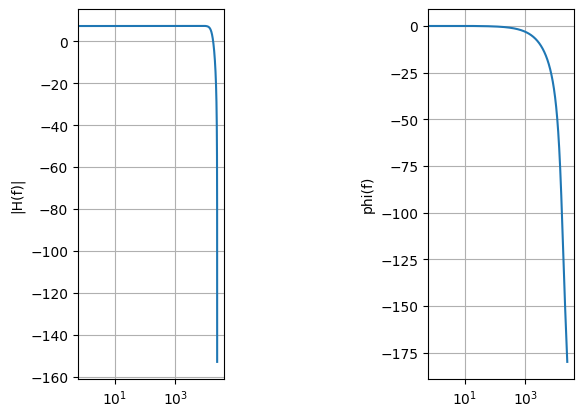

In [2]:
def Transferfunction(a, b, r):
    f = np.arange(r/2)
    N = 0
    D = 1
    for k in range(b.shape[0]):
        N += b[k] * np.exp(-1j*2*np.pi*f*k/r)
    for l in range(1, a.shape[0]):
        D += a[l] * np.exp(-1j*2*np.pi*f*l/r)
    H = N / D
    return H, f

def BodePlotIIRFilter(a, b, r):
    H, f = Transferfunction(a, b, r)
    plt.subplot(131)
    plt.semilogx(f, 20*np.log10(np.abs(H)))
    plt.ylabel('|H(f)|')
    plt.grid(which='both', axis='both')
    plt.subplot(133)
    plt.semilogx(f, np.angle(H, deg=True))
    plt.ylabel('phi(f)')
    plt.grid(which='both', axis='both')
    plt.show()    

r = 48000
BodePlotIIRFilter(a, b, r)

## Stability, Poles, Zeros
An IIR filter is stable, if all poles of $H(z)$ are inside the unit circle:

$H(z)=\frac{\sum_{k=0}^K b_k\cdot z^{-k}}{1+\sum_{l=1}^L a_l\cdot z^{-l}}$

Evaluating the zeros $z_{0,k}$:

$\sum_{k=0}^K b_k\cdot z_{0,k}^{-k} = 0$

Evaluating the poles $z_{p,l}$:

$1+\sum_{l=1}^L a_l\cdot z_{p,l}^{-l} = 0$

The evaluated poles and zeros are usually plotted in a pole zero diagram of the complex plain, as shown below.

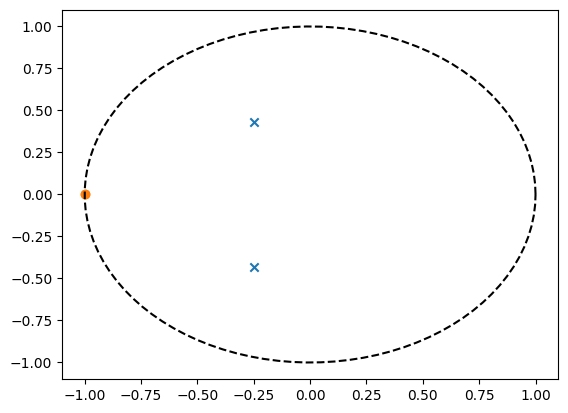

In [3]:
def IsStableIIRFilter(a, b):
    DenominatorRoots = np.roots(a)
    return np.amax(np.abs(DenominatorRoots)) < 1.0

def PlotZerosPolesIIRFilter(a, b):
    NumeratorRoots = np.roots(b)
    DenominatorRoots = np.roots(a)
    phi = np.arange(100) / 99 * 2 * np.pi
    plt.plot(np.cos(phi), np.sin(phi), '--k') # plot the unit circle
    plt.scatter(DenominatorRoots.real, DenominatorRoots.imag, marker = 'x') # plot the roots
    plt.scatter(NumeratorRoots.real, NumeratorRoots.imag, marker = 'o') # plot the zeros
    plt.show()

IsStableIIRFilter(a, b)
PlotZerosPolesIIRFilter(a, b)

## Programming exercise:

The following equation is given: $y(n) = a\cdot y(n-1) + (1-a)\cdot x(n)$ with $3-\sqrt{8}<|a|<1$

Write the code for the procedure to evaluate the transfer function.

Write the code for the procedure to evaluate the cutoff frequency depending on the damping parameter $a$.

Hint: the given equation is a lowpass filter with highest magnitude at $f=0$ Hz.

Write the code for the procedure to evaluate the parameter $a$ depending on the cutoff frequency.

In [15]:
def TransferFunction(f, r, a):
    H = 1
    ### solution
    H = (1-a) / (1-a*np.exp(-1j*2*np.pi*f/r))
    ### solution
    return H

def DampingParameter2CutoffFrequency(a, r):
    ### solution
    assert np.abs(a) < 1.0, '|a| is too large'
    assert np.abs(a) > 3-np.sqrt(8), '|a| is too small'
    fc =  r / (2*np.pi) * np.arccos((1-4*a+a**2) / (-2*a))
    ### solution
    return fc

def CutoffFrequency2DampingParameter(fc, r):
    a = 0
    ### solution
    assert fc > 0, 'cutoff frequency must be greater 0'
    assert 2*fc < r, 'cutoff frequency must be smaller r/2'
    p_half = np.cos(2*np.pi*fc/r)-2
    a = -p_half - np.sqrt(p_half**2-1) # p-q-equation for solving squared polynomials
    ### solution
    return a

import unittest

class TestProgrammingExercise(unittest.TestCase):

    def test_TransferFunction(self):
        f = 1500
        r = 16000
        a = 0.75
        self.assertAlmostEqual(0.2984-0.3304j, TransferFunction(f, r, a), delta = 1e-1)
        f = 12000
        r = 32000
        a = 0.9        
        self.assertAlmostEqual(0.05308-0.02064j, TransferFunction(f, r, a), delta = 1e-1)
        f = 12000
        r = 32000
        a = -0.9        
        self.assertAlmostEqual(1.286+2.2508j, TransferFunction(f, r, a), delta = 1e-1)

    def test_DampingParameter(self):
        for r in [16000, 32000, 44100]:
            a = 0.9
            fc = DampingParameter2CutoffFrequency(a, r)
            self.assertAlmostEqual(fc, r*0.016784, delta = 1e-2)
            a = 0.7
            fc = DampingParameter2CutoffFrequency(a, r)
            self.assertAlmostEqual(fc, r*0.057378, delta = 1e-2)

    def test_CutoffFrequency1(self):
        r = 44100
        fc = r/5
        a = CutoffFrequency2DampingParameter(fc, r)
        self.assertAlmostEqual(a, 0.32737619817917585, delta = 1e-7)
        r = 16000
        fc = r/7
        a = CutoffFrequency2DampingParameter(fc, r)
        self.assertAlmostEqual(a, 0.4305819103800278, delta = 1e-7)
    
    def test_CutoffFrequency2(self):
        r = 16000
        x = 2/3
        for n in range(100):
            x = (x-x**2)*4
            assert x > 0.0, 'input too small'
            assert x < 1.0, 'input too large'
            fc = x*r/2        
            a = CutoffFrequency2DampingParameter(fc, r)
            self.assertAlmostEqual(np.abs(TransferFunction(fc, r, a)), 1/np.sqrt(2), delta = 1e-2)
            self.assertGreater(np.abs(TransferFunction((0 + fc) * 0.5, r, a)), 1/np.sqrt(2))
            self.assertLess(np.abs(TransferFunction((r/2 + fc) * 0.5, r, a)), 1/np.sqrt(2))

    def test_RandomInversion(self):
        r = 48000
        x = 2/3
        for n in range(100):
            x = (x-x**2)*4
            assert x > 0.0, 'input too small'
            assert x < 1.0, 'input too large'
            fc = x*r/2
            a = CutoffFrequency2DampingParameter(fc, r)
            self.assertAlmostEqual(fc, DampingParameter2CutoffFrequency(a, r), delta = 1e-1)
            
# https://stackoverflow.com/questions/40172281/unit-tests-for-functions-in-a-jupyter-notebook
unittest.main(argv=[''], verbosity=2, exit=False)

test_CutoffFrequency1 (__main__.TestProgrammingExercise.test_CutoffFrequency1) ... ok
test_CutoffFrequency2 (__main__.TestProgrammingExercise.test_CutoffFrequency2) ... ok
test_DampingParameter (__main__.TestProgrammingExercise.test_DampingParameter) ... ok
test_RandomInversion (__main__.TestProgrammingExercise.test_RandomInversion) ... ok
test_TransferFunction (__main__.TestProgrammingExercise.test_TransferFunction) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.030s

OK


## Exam preparation

1) For which $a$ is the following equation $y(n) = a\cdot y(n-1) + (1-a)\cdot x(n)$ stable?

2) Evaluate the cutoff frequency $f_c$ of the IIR filter given in 1) depending on the damping parameter $a$.

3) How do you have to change the equation $y(n) = a\cdot y(n-1) + (1-a)\cdot x(n)$ in order to create a highpass?

4) The filter of 1) has the impulse response $h(n) = (1-a) \cdot a^n$. Evaluate the smallest possible $n_0$ for which the following statement is valid: $h(n_0) < h(n=0)\cdot e^{-5}$. This $n_0$ can be interpreted as the reasonable length of the impulse response. For $n > n_0$, the impulse response can be interpreted as stationary.

5) An audio interface has a sampling rate of $r=48$ kHz. For denoising purposes, the signal is filtered by a bandpass with cutoff frequencies $f_{c,1}=100$ Hz and $f_{c,2}=7$ kHz. Has the audio signal a zero mean after the filter? Is human speech capable of passing this filter? Would this filter suppress hum noise at $50$ Hz?